In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from contexttimer import Timer
import math
import matplotlib.pyplot as plt
import numpy
import typing as tp

In [3]:
%matplotlib inline

# Importing Cocos and Selecting a Device

## Importing Cocos

Import Cocos numerics API which offers a NumPy like API

In [4]:
import cocos.numerics as cn

Import the Cocos device management module

In [5]:
import cocos.device as cd

## Choosing a Backend (Optional)

Cocos supports execution on CUDA, OpenCL, or the CPU itself. The most appropriate backend is typically selected automatically. But the desired backend architecture can be specified explitly via `cd.init(backend)`, where backend is one of `cpu`, `cuda`, or `opencl`.

In [6]:
cd.init(backend=None)

## Selecting Compute Devices

### To simply list all available compute devices we can use `cd.info()`

In [7]:
cd.info()

Cocos running on ArrayFire v3.6.4 (CUDA 64bit)
[0] v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1
-1- v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1


This computer has both a discrete AMD Radeon chip as well as a graphics unit integrated into the Intel CPU, both of which support OpenCL and can be used with Cocos.

### To query and select GPU devices programatically we use the `ComputeDeviceManager`

In [8]:
all_compute_devices = cd.ComputeDeviceManager.get_compute_devices()
for compute_device in all_compute_devices:
    print(compute_device)

0: GeForce_GTX_1060_6GB | CUDA - v10.0 | compute version 6.1
1: GeForce_GTX_1060_6GB | CUDA - v10.0 | compute version 6.1


### If a discrete GPU is present we usually want to work on this one rather than the integrated GPU which is typically much less powerful. Here is how we can exclude integrated GPUs, which may appear in the device list when using the OpenCL backend.

In [9]:
discrete_compute_devices = list(filter(lambda x: 'intel' not in x.name.lower(), 
                               cd.ComputeDeviceManager.get_compute_devices()))

for compute_device in discrete_compute_devices:
    print(compute_device)

0: GeForce_GTX_1060_6GB | CUDA - v10.0 | compute version 6.1
1: GeForce_GTX_1060_6GB | CUDA - v10.0 | compute version 6.1


### We can set the active compute device either by id ...

In [10]:
cd.ComputeDeviceManager.set_compute_device(len(all_compute_devices) - 1)
cd.info()

Cocos running on ArrayFire v3.6.4 (CUDA 64bit)
-0- v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1
[1] v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1


### ... or via a compute device object

In [11]:
cd.ComputeDeviceManager.set_compute_device(discrete_compute_devices[0])
cd.info()

Cocos running on ArrayFire v3.6.4 (CUDA 64bit)
[0] v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1
-1- v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1


# First Steps

### Create a 2x2 matrix from nested lists

In [12]:
a = cn.array([[1.0, 2.0], [3.0, 4.0]])
print(a)

[[1. 2.]
 [3. 4.]]


### Create a 2x1 vector from nested lists

In [13]:
b = cn.array([[5.0], [6.0]])
print(b)

[5. 6.]


### Matrix product of b and a

In [14]:
c = a @ b
print(c)

[17. 39.]


### Create an array of normally distributed random numbers

In [15]:
d = cn.random.randn(2, 2)
print(d)

[[1.74057    0.481135  ]
 [0.14043704 0.82822126]]


# Application: Estimating $\pi$ via Monte-Carlo

The following function takes advantage of the fact that Cocos mimics NumPy's API. It imports the numerical package to use based on the parameter `gpu` and can use the same exact code for both CPU and GPU calculations.

In [16]:
import time
import cocos.device as cd

def estimate_pi(n: int, gpu: bool = True) -> float:
    if gpu:
        import cocos.numerics as np
        import cocos.numerics.random as random
    else:
        import numpy as np
        import numpy.random as random

    x = np.random.rand(n)
    y = np.random.rand(n)
    in_quarter_circle = (x * x + y * y) <= 1.0
    estimate = int(np.sum(in_quarter_circle))

    return estimate / n * 4

Print information regarding the available devices in the machine

In [17]:
cd.info()

Cocos running on ArrayFire v3.6.4 (CUDA 64bit)
[0] v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1
-1- v10.0: GeForce GTX 1060 6GB | CUDA | compute version 6.1


Set the number of Monte-Carlo replications

In [18]:
n = 100000000

First, run the estimation of $\pi$ on the CPU via NumPy

In [19]:
pi_cpu = estimate_pi(n, gpu=False)
print(f'Estimate of Pi on cpu: {pi_cpu}')

Estimate of Pi on cpu: 3.14180304


Now use Cocos to run the same code on the GPU

In [20]:
pi_gpu = estimate_pi(n, gpu=True)
print(f'Estimate of Pi on gpu: {pi_gpu}')

Estimate of Pi on gpu: 3.14149676


Run a benchmark - repeating the simulation R times on both cpu and gpu

In [21]:
R = 10

# on gpu
tic = time.time()
with Timer() as gpu_timer:
    for r in range(R):
        pi_gpu = estimate_pi(n, gpu=True)
        cd.sync()

print(f'time elapsed on gpu: {gpu_timer.elapsed}')

# on cpu
with Timer() as cpu_timer:
    for r in range(R):
        pi_cpu = estimate_pi(n, gpu=False)

print(f'time elapsed on cpu: {cpu_timer.elapsed}')

# compute and print the speedup factor
print(f'speedup factor on gpu: {cpu_timer.elapsed/gpu_timer.elapsed}')

time elapsed on gpu: 0.12467640000000024
time elapsed on cpu: 17.6124766
speedup factor on gpu: 141.2655209807146


# Application: Quantifying Risk in a Stochastic Volatility Model via Simulation

We are modeling the log price of an equity index using Heston's classical 1992 stochastic volatility. 

The log price ($x$) and its instantanous variance ($V$) are governed by the following system of stochastic differential equations (SDE):

$
d x_t = \left( \mu - \frac{1}{2} \sqrt{V_t} \right) dt + \sqrt{V_t} dB_{1, t}
$

$
d V_t = \kappa \left( \bar{V} - V_t \right) dt + \sigma_V \sqrt{V_t} \left( \rho d B_{1, t} + \sqrt{1 - \rho^2} d B_{2, t} \right)
$


In this setup, $\mu$ denotes the instantaneously expected return of the equity index. $V$ is a mean reverting square root diffusion with target $\bar{V}$, mean-reversion speed $\kappa$, and volatility of volatility $\sigma_v$. The instantaneous correlation between innovations to the log price and the volatility process is $\rho$.

In this example, we are simulating sample paths via a (first-order) Euler–Maruyama discretization with time step $\Delta t$. In practice, one would use a higher order method or apply a Doss transformation.

The dynamics of the discretized process are  

$
x_t = x_{t-1} + \left( \mu - \frac{1}{2} \sqrt{V_{t-1}} \right) \Delta t + \sqrt{V_{t-1}} \sqrt{\Delta t} \epsilon_{x, t}
$

$
V_t = V_{t-1} + \kappa \left( \bar{V} - V_{t-1} \right) \Delta t + \sigma_V \sqrt{V_{t-1}} \sqrt{\Delta t}  \left( \rho \epsilon_{x, t} + \sqrt{1 - \rho^2} \epsilon_{V, t} \right),
$

where $\{\epsilon_{x, t}, \epsilon_{V, t}\}_{t=0}^{T \Delta t}$ is an i.i.d. sequence of concorrelated bivariate standard normal distributions.

## Simulation Code

We are using the Cocos convenience function `randn_antithetic` to generate arrays of antithetic standard normal random variables.

In [22]:
from cocos.numerics.random import randn_antithetic

In [23]:
def simulate_heston_model(T: float,
                          N: int,
                          R: int,
                          mu: float,
                          kappa: float,
                          v_bar: float,
                          sigma_v: float,
                          rho: float,
                          x0: float,
                          v0: float,
                          gpu: bool = False):
    if gpu:
        import cocos.numerics as np
        import cocos.numerics.random as random
    else:
        import numpy as np
        import numpy.random as random

    Delta_t = T / float(N - 1)

    x = [np.full((R,), x0, dtype=numpy.float32),
         np.zeros((R,), dtype=numpy.float32)]

    v = [np.full((R,), v0, dtype=numpy.float32),
         np.zeros((R,), dtype=numpy.float32)]

    sqrt_delta_t = math.sqrt(Delta_t)
    sqrt_one_minus_rho_square = math.sqrt(1 - rho ** 2)

    m = np.zeros((2,), dtype=numpy.float32)
    m[0] = rho
    m[1] = sqrt_one_minus_rho_square
    zero_array = np.zeros((R,), dtype=numpy.float32)

    t_current = 0
    for t in range(1, N):
        t_previous = (t + 1) % 2
        t_current = t % 2

        # generate antithetic standard normal random variables
        dBt = randn_antithetic(shape=(R, 2),
                               antithetic_dimension=0,
                               num_pack=np) * sqrt_delta_t

        sqrt_v_lag = np.sqrt(v[t_previous])
        x[t_current] = x[t_previous] \
                     + (mu - 0.5 * v[t_previous]) * Delta_t \
                     + np.multiply(sqrt_v_lag, dBt[:, 0])
        v[t_current] = v[t_previous] \
                     + kappa * (v_bar - v[t_previous]) * Delta_t \
                     + sigma_v * np.multiply(sqrt_v_lag, np.dot(dBt, m))
        v[t_current] = np.maximum(v[t_current], numpy.finfo(numpy.float32).eps)

    x = x[t_current]
    v = np.maximum(v[t_current], numpy.finfo(numpy.float32).eps)

    return x, v

## Parameters

Model Parameters

In [24]:
x0 = 0.0  # initial log stock price
v0 = 0.101 ** 2  # initial volatility
r = math.log(1.0319)  # risk-free rate
rho = -0.7  # instantaneous correlation between Brownian motions
sigma_v = 0.61  # variance of volatility
kappa = 6.21  # mean reversion speed
v_bar = 0.019  # mean variance

Time Horizon

In [25]:
T = 1.0

Simulation Parameters

In [26]:
nT = int(math.ceil(500 * T))  # number of time-steps to simulate
R = 1000000  # actual number of paths to simulate for pricing

## Run Simulation on CPU and GPU

Simulate one path to compile GPU kernels

In [27]:
simulate_heston_model(T=T,
                      N=nT,
                      R=2, 
                      mu=r, 
                      kappa=kappa, 
                      v_bar=v_bar, 
                      sigma_v=sigma_v, 
                      rho=rho, 
                      x0=x0, 
                      v0=v0, 
                      gpu=True)


(array([-0.0916823 ,  0.13830945], dtype=float32),
 array([0.05445173, 0.00223316], dtype=float32))

In [28]:
with Timer() as heston_gpu_timer:
    x_simulated_gpu, v_simulated_gpu \
        = simulate_heston_model(T=T,
                                N=nT,
                                R=R,
                                mu=r,
                                kappa=kappa,
                                v_bar=v_bar,
                                sigma_v=sigma_v,
                                rho=rho,
                                x0=x0,
                                v0=v0,
                                gpu=True)
    
    # Force Cocos to evaluate the code
    cd.sync()

In [29]:
with Timer() as heston_cpu_timer:
    x_simulated_cpu, v_simulated_cpu \
        = simulate_heston_model(T=T,
                                N=nT,
                                R=R,
                                mu=r,
                                kappa=kappa,
                                v_bar=v_bar,
                                sigma_v=sigma_v,
                                rho=rho,
                                x0=x0,
                                v0=v0,
                                gpu=False)

In [30]:
print(f'GPU speedup: {heston_cpu_timer.elapsed/heston_gpu_timer.elapsed}')

GPU speedup: 3.5871321096082496


## Kernel Density Estimation

In [31]:
from cocos.scientific.kde import (
    gaussian_kde, 
    evaluate_gaussian_kde_in_batches, 
)

In [32]:
gaussian_kde_cpu = gaussian_kde(numpy.exp(x_simulated_cpu), gpu=False)

In [33]:
gaussian_kde_gpu = gaussian_kde(numpy.exp(x_simulated_gpu), gpu=True)

Construct a grid at which to evaluate the simulated equity index prices

In [34]:
grid_size = 1001
grid = numpy.linspace(0, 2.0, grid_size)

KDE on CPU

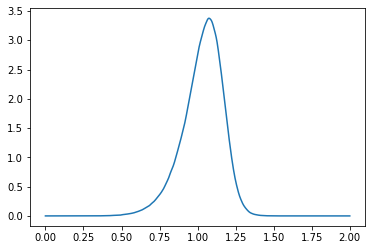

In [35]:
with Timer() as kde_cpu_timer:
    kernel_density_estimate_cpu = gaussian_kde_cpu.evaluate(grid)

plt.plot(grid, kernel_density_estimate_cpu, label='gaussian kernel density estimated using NumPy');

KDE on GPU

In [36]:
# with Timer() as kde_gpu_timer:
#     kernel_density_estimate_gpu = \
#         gaussian_kde_gpu.evaluate_in_batches(points=numpy.atleast_2d(grid), 
#                                              maximum_number_of_elements_per_batch=5000000)
# plt.plot(grid, kernel_density_estimate_gpu, label='gaussian kernel density estimated using Cocos');
# del kernel_density_estimate_gpu

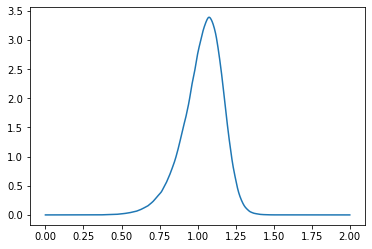

In [44]:
with Timer() as kde_gpu_timer:
    kernel_density_estimate_gpu = \
        evaluate_gaussian_kde_in_batches(gaussian_kde_gpu, 
                                         points=numpy.atleast_2d(grid), 
                                         maximum_number_of_elements_per_batch=5000000)
plt.plot(grid, kernel_density_estimate_gpu, label='gaussian kernel density estimated using Cocos');
del kernel_density_estimate_gpu

In [45]:
print(f'GPU speedup: {kde_cpu_timer.elapsed/kde_gpu_timer.elapsed}')

GPU speedup: 19.61636313466146


Multi-GPU Processing

In [46]:
from cocos.multi_processing.device_pool import (
    ComputeDevicePool, 
    MultiprocessingPoolType
)

In [47]:
gpu_pool = ComputeDevicePool(multiprocessing_pool_type=MultiprocessingPoolType.LOKY)
gpu_pool.number_of_devices

2

In [48]:
kernel_density_estimate_multi_gpu = \
    gaussian_kde_cpu.evaluate_in_batches_on_multiple_gpus(points=numpy.atleast_2d(grid),
                                                          maximum_number_of_elements_per_batch=5000000, 
                                                          gpu_pool=gpu_pool)


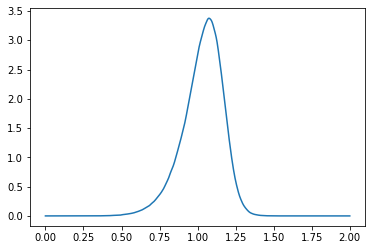

In [49]:
with Timer() as kde_multi_gpu_timer:
    kernel_density_estimate_multi_gpu = \
        gaussian_kde_cpu.evaluate_in_batches_on_multiple_gpus(points=numpy.atleast_2d(grid),
                                                              maximum_number_of_elements_per_batch=5000000, 
                                                              gpu_pool=gpu_pool)
plt.plot(grid, kernel_density_estimate_multi_gpu, label='gaussian kernel density estimated using Cocos');
del kernel_density_estimate_multi_gpu

In [50]:
print(f'Multi GPU vs CPU speedup: {kde_cpu_timer.elapsed/kde_multi_gpu_timer.elapsed}')
print(f'Multi GPU vs Single GPU speedup: {kde_gpu_timer.elapsed/kde_multi_gpu_timer.elapsed}')

Multi GPU vs CPU speedup: 31.921337963326582
Multi GPU vs Single GPU speedup: 1.6272811501395303
